# Infomación de entrega

**Nombre estudiante:** Fernando Canales Pérez


## 0) Setup

In [97]:
!pip install keras --upgrade

In [98]:
# Importar librerías
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1) Carga del dataset

El dataset Cora consiste en 2.708 papers científicos clasificados en una de 7 posibles clases. La red de citas/referencias consiste en 5.429 arcos. Cada paper tiene un vector de palabras binario de tamaño 1.433, indicando la presencia o ausencia de la palabra correspondiente.

El dataset tiene dos archivos separados:

1. El archivo `cora.cites` incluye las citas/referencias en dos columnas:
`cited_paper_id` (*target*) y `citing_paper_id` (*source*).
2. El archivo `cora.content` incluye una descripción del contenido del paper en 1.435 columnas: `paper_id`, `subject`, y 1.433 *features* binarias.


In [99]:
# Descarga de datos
!mkdir -p ./data/cora
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -O ./data/cora.tgz
!tar -xvzf ./data/cora.tgz -C ./data/cora/ --strip-components=1

--2025-11-15 19:25:52--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.56.80
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.56.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘./data/cora.tgz’

./data/cora.tgz     100%[===================>] 164.11K  --.-KB/s    in 0.08s   

2025-11-15 19:25:53 (2.02 MB/s) - ‘./data/cora.tgz’ saved [168052/168052]

cora/README
cora/cora.cites
cora/cora.content


In [100]:
# Cargar datos utilizando pandas
# Cargar el archivo de citas
citations = pd.read_csv('./data/cora/cora.cites', sep='\t', header=None, names=['target', 'source'])

# Cargar el archivo de contenido
column_names = ['paper_id'] + [f'feature_{i}' for i in range(1433)] + ['subject']
papers = pd.read_csv('./data/cora/cora.content', sep='\t', header=None, names=column_names)

In [101]:
# Métricas básicas del dataset
print("=" * 60)
print("MÉTRICAS DEL DATASET CORA")
print("=" * 60)

print(f"\n📄 PAPERS (Nodos):")
print(f"  - Total de papers: {len(papers)}")
print(f"  - Columnas: {papers.shape[1]}")
print(f"  - Número de features: {len(papers.columns) - 2}")  # Excluyendo paper_id y subject

print(f"\n🔗 CITAS (Aristas):")
print(f"  - Total de citas: {len(citations)}")
print(f"  - Aristas dirigidas: {len(citations)}")

print(f"\n📚 CATEGORÍAS:")
print(f"  - Número de clases: {papers['subject'].nunique()}")
print(f"  - Clases: {sorted(papers['subject'].unique())}")

print(f"\n📊 DISTRIBUCIÓN DE CLASES:")
class_distribution = papers['subject'].value_counts().sort_index()
for subject, count in class_distribution.items():
    percentage = (count / len(papers)) * 100
    print(f"  - {subject}: {count} papers ({percentage:.1f}%)")

print(f"\n🔍 PRIMERAS FILAS DE PAPERS:")
print(papers.head())

print(f"\n🔍 PRIMERAS FILAS DE CITATIONS:")
print(citations.head())

print("\n" + "=" * 60)

MÉTRICAS DEL DATASET CORA

📄 PAPERS (Nodos):
  - Total de papers: 2708
  - Columnas: 1435
  - Número de features: 1433

🔗 CITAS (Aristas):
  - Total de citas: 5429
  - Aristas dirigidas: 5429

📚 CATEGORÍAS:
  - Número de clases: 7
  - Clases: ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

📊 DISTRIBUCIÓN DE CLASES:
  - Case_Based: 298 papers (11.0%)
  - Genetic_Algorithms: 418 papers (15.4%)
  - Neural_Networks: 818 papers (30.2%)
  - Probabilistic_Methods: 426 papers (15.7%)
  - Reinforcement_Learning: 217 papers (8.0%)
  - Rule_Learning: 180 papers (6.6%)
  - Theory: 351 papers (13.0%)

🔍 PRIMERAS FILAS DE PAPERS:
   paper_id  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     31336          0          0          0          0          0          0   
1   1061127          0          0          0          0          0          0   
2   1106406          0          0          0  

#### Preguntas

Una vez cargado el dataset debes responder las siguientes preguntas:

1. ¿Qué tipos de nodos y aristas tiene el grafo?

2. ¿Cuántas features tiene cada nodo?

3. ¿Cuántos nodos y aristas forman el grafo?


#### Respuestas

1. El grafo es homogéneo, o sea, solo tiene un tipo de nodo y un tipo de arista. Los nodos representan papers científicos, y las aristas representan citas entre esos papers. Si hay una arista de A a B, significa que el paper A cita al paper B. Las aristas son dirigidas, porque citar a alguien no significa que el otro paper te cite de vuelta. Esto lo diferencia de otros grafos como redes sociales donde las conexiones son muchas veces bidireccionales.

2. Cada nodo tiene 1,433 features. Estas features son binarias y vienen de una representación tipo bag-of-words, donde cada feature indica si cierta palabra aparece o no en el paper. Además, cada nodo tiene una etiqueta de clase, pero esa no se considera una feature de entrada, sino el valor que queremos predecir.

3. El grafo tiene 2,708 nodos (los papers) y 5,429 aristas (citas entre ellos). Es un grafo pequeño pero muy usado en investigaciones de GNN. También es bastante disperso: en promedio, cada paper cita alrededor de 2 papers, lo cual es normal en redes de citación donde no todos los nodos están conectados entre sí.

4. ...
5. ...

## 2) Análisis del grafo

Un paso importante antes de aplicar *machine learning* sobre un conjunto de datos es el análisis de datos. Para esto, aprovecharemos de usar la librería NetworkX para obtener información sobre nuestro grafo.

Grado promedio: 4.01
Diámetro: 19
Densidad: 0.000741


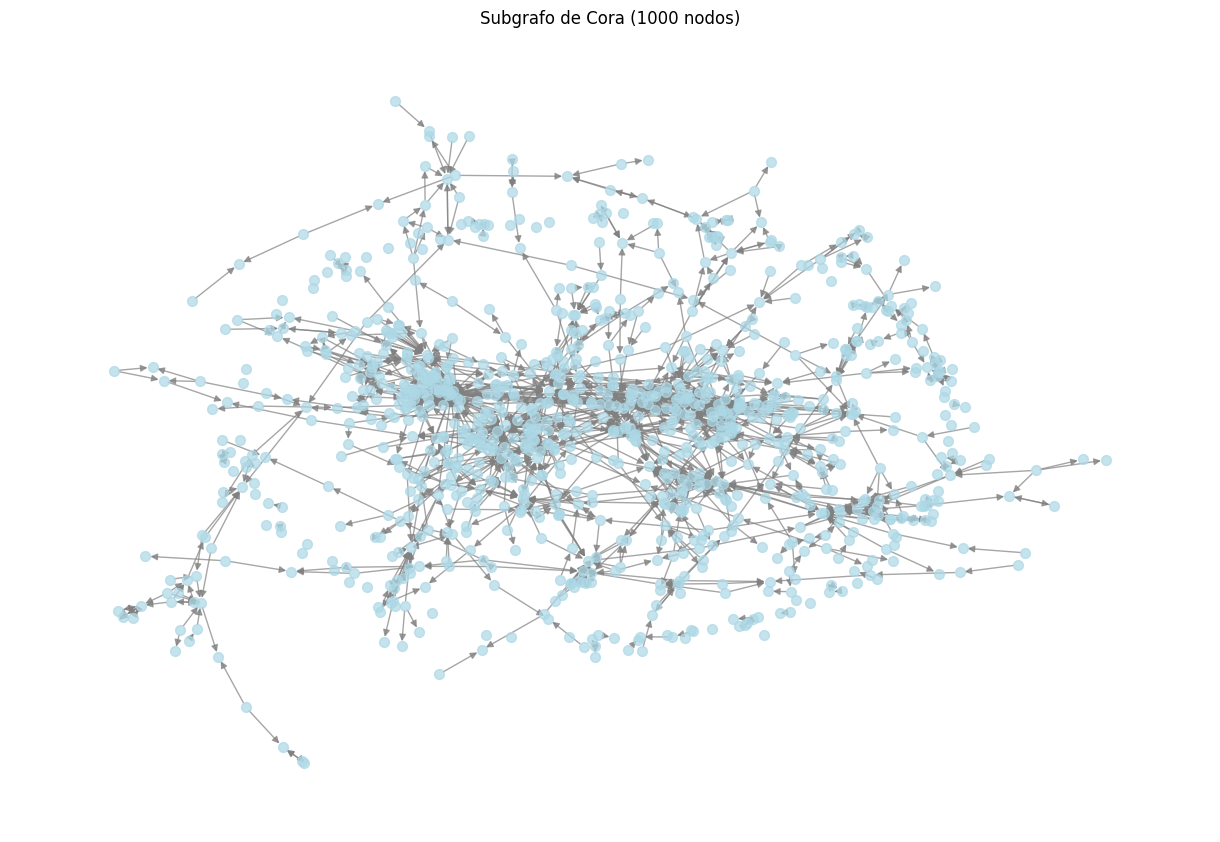

In [102]:
# Crear grafo en NetworkX con datos cargados
# Crear grafo dirigido en NetworkX
G = nx.DiGraph()

# Agregar nodos
for idx, row in papers.iterrows():
    G.add_node(row['paper_id'], subject=row['subject'])

# Agregar aristas
for idx, row in citations.iterrows():
    G.add_edge(row['source'], row['target'])

# Respuestas a las preguntas:

# 1. Grado promedio
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Grado promedio: {avg_degree:.2f}")

# 2. Diámetro del grafo (trabajar con componente más grande si no es conexo)
if nx.is_weakly_connected(G):
    diameter = nx.diameter(G.to_undirected())
else:
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc).to_undirected()
    diameter = nx.diameter(subgraph)
print(f"Diámetro: {diameter}")

# 3. Densidad de la matriz de adyacencia
density = nx.density(G)
print(f"Densidad: {density:.6f}")

# 4. Visualización de un subgrafo
subgraph_nodes = list(G.nodes())[:1000]
subG = G.subgraph(subgraph_nodes)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.5, iterations=50)
nx.draw(subG, pos, node_size=50, node_color='lightblue',
        edge_color='gray', arrows=True, alpha=0.7)
plt.title("Subgrafo de Cora (1000 nodos)")
plt.show()

#### Preguntas

Una vez instanciado el grafo, debes responder las siguientes preguntas utilizando NetworkX:

1. ¿Cuál es el grado promedio de los nodos en el grafo?

2. ¿Cuál es el diámetro del grafo?

3. ¿Cuál es la densidad de la matriz de adyacencia del grafo?

4. Realizar un gráfico mostrando los nodos (un subconjunto) y sus arcos respectivos

### Respuestas

* Grado promedio: 4.01
* Diámetro: 19
* Densidad: 0.000741
* Gráfico mostrando en la celda anterior a esta.


## 3) Split del dataset


Otro paso importante es realizar la partición de datos etiquetados en conjuntos de entrenamiento y test. Para esto, para cada etiqueta, se debe tomar la mitad de los papers para cada conjunto (50%).

In [103]:
# Partición de datos en train y test como numpy array

# Crear mapeo de paper_id a índice
paper_ids = papers['paper_id'].values
node_id_to_idx = {paper_id: idx for idx, paper_id in enumerate(paper_ids)}

# Preparar features (todas las columnas excepto paper_id y subject)
feature_columns = [col for col in papers.columns if col.startswith('feature_')]
node_features = papers[feature_columns].values.astype(np.float32)

# Preparar labels
subject_to_label = {subject: idx for idx, subject in enumerate(papers['subject'].unique())}
labels = papers['subject'].map(subject_to_label).values

# Preparar edges en formato COO
edges_list = []
for idx, row in citations.iterrows():
    if row['source'] in node_id_to_idx and row['target'] in node_id_to_idx:
        source_idx = node_id_to_idx[row['source']]
        target_idx = node_id_to_idx[row['target']]
        edges_list.append([source_idx, target_idx])

edges = np.array(edges_list).T  # Shape: [2, num_edges]

# Split estratificado 50%-50% por clase
train_indices, test_indices = train_test_split(
    np.arange(len(labels)),
    test_size=0.5,
    stratify=labels,
    random_state=42
)

train_labels = labels[train_indices]
test_labels = labels[test_indices]


In [104]:
# Crear graph_info
graph_info = (node_features, edges)
num_classes = len(subject_to_label)

> **Nota:** Recuerda que para los modelos GNN, en clases utilizamos:
> - `graph_info`: tupla `(node_features, edges)` donde:
>   - `node_features`: array de forma `[num_nodes, num_features]` con las features de todos los nodos
>   - `edges`: array de forma `[2, num_edges]` en formato COO con las aristas del grafo
> - Para entrenar, pasarás los **índices de los nodos** de entrenamiento (no las features directamente)
> - El modelo usará `tf.gather` internamente para obtener las features de los nodos especificados

#### Preguntas

1. ¿En qué formato se encuentran almacenados los splits?
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no haceerlo de manera estratificada)?
3. ¿Estamos en presencia de un contexto inductivo o transductivo?
4. Mencione un ejemplo de técnica de *data augmentation* que podría aplicar en este conjunto de datos.
5. Si tuviéramos los *timestamps* de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

#### **RESPUETAS:**

1. Los splits están guardados como arrays de NumPy con índices.
Esto significa que no guardamos los datos completos, sino solo los números que indican qué nodos van a train, test o validation. Por ejemplo: [0, 3, 10, 25...]. En GNN hacemos esto porque trabajamos con el grafo completo, y luego usamos funciones como tf.gather() para seleccionar solo los nodos que vamos a usar en cada paso.

2. Si no hacemos el split de forma estratificada, podríamos terminar con un desbalance grande entre clases. Por ejemplo, podríamos tener muchas muestras de una clase en train y casi ninguna en test, o al revés. En el peor caso, una clase podría quedar solo en train o solo en test, lo que hace que el modelo aprenda mal y tenga resultados muy malos.
Por eso usamos stratify=labels: para mantener las proporciones de todas las clases en los splits.

3. Estamos en un contexto transductivo. Esto significa que el modelo ve todo el grafo desde el principio, con todas las conexiones (edges) y todos los nodos. La única diferencia es que no usamos las etiquetas de test durante el entrenamiento, pero los nodos de test igual están presentes en el grafo. No es inductivo, porque en inductivo el modelo entrena con un subgrafo y después debe predecir sobre nodos totalmente nuevos que nunca vio.

4. Un ejemplo sería Edge Dropping. Esta técnica consiste en eliminar aleatoriamente un porcentaje de las aristas cada vez que entrenamos. Por ejemplo, quitar el 10% de edges en cada época. Esto ayuda a que el modelo no dependa demasiado de una estructura exacta y sea más robusto, parecido al dropout en redes neuronales normales.

5. Sí, totalmente. Podríamos hacer un split temporal, que es más realista. La idea sería usar los papers antiguos para entrenamiento y los más recientes para test. Por ejemplo, entrenar con papers antes de 2010 y testear con los de 2010 en adelante. Esto evita “mirar el futuro” sin querer y refleja mejor cómo usaríamos el modelo en una aplicación real donde siempre llegan papers nuevos.

## 4) Creacion de la red

### GCN

En este paso, deberás crear una GCN. Para esto, deberás definir la clase `GraphConvLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = \text{ADD}(\text{MEAN}(\{W^{(l)} \times h_u^{(l-1)}, u\in N(v)\}), W^{(l)} \times h_v^{(l-1)})$

**Nota importante:** En esta fórmula, `ADD` se refiere a la suma elemento a elemento (element-wise addition), no a concatenación.

**Pasos detallados:**

1. **Cálculo del mensaje:** Aplicar una transformación lineal (FFN) a las representaciones de los vecinos: $W^{(l)} \times h_u^{(l-1)}$ para cada vecino $u \in N(v)$
2. **Agregación:** Calcular el promedio de los mensajes de los vecinos usando `tf.math.unsorted_segment_mean`
3. **Actualización:** Sumar elemento a elemento (usar `tf.add` o `+`) los mensajes agregados con la representación transformada del nodo actual $W^{(l)} \times h_v^{(l-1)}$

**Estructura de datos del grafo:**

- `graph_info` debe ser una tupla: `(node_features, edges)`
  - `node_features`: tensor de forma `[num_nodes, num_features]`
  - `edges`: tensor de forma `[2, num_edges]` en formato COO (Coordinate format)
    - `edges[0]` contiene los índices de los nodos fuente (source)
    - `edges[1]` contiene los índices de los nodos destino (target)
- Para obtener las representaciones de los vecinos, usa `tf.gather(node_representations, neighbour_indices)`

Por otra parte, para definir la GCN deberás definir la clase `GCNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GCNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphConvLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

**Notas sobre la FFN:**

- Cada capa densa de una FFN deberá utilizar en este orden: *batch normalization* → *dropout* (0.3) → *Dense* con activación ReLU
- Asegúrate que las capas internas sean parte del modelo (usar `self.` para almacenarlas)

In [105]:
# Hiperparámetros GCN (definir como CONSTANTES)

HIDDEN_UNITS = [8, 16]
DROPOUT_RATE = 0.3
NUM_CLASSES = 7  # Número de clases en el dataset Cora
LEARNING_RATE = 0.01
EPOCHS = 100


In [106]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

def create_ffn(hidden_units, dropout_rate, name=None):
    """
    Crea una Feed-Forward Network (FFN) con batch normalization y dropout.

    Args:
        hidden_units: Lista con el número de unidades ocultas por capa
        dropout_rate: Tasa de dropout a aplicar
        name: Nombre opcional para el Sequential

    Returns:
        Un modelo Sequential con las capas especificadas
    """
    fnn_layers = []

    for units in hidden_units:
      fnn_layers.append(layers.Dense(units))
      fnn_layers.append(layers.BatchNormalization())
      fnn_layers.append(layers.ReLU())
      fnn_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(fnn_layers, name=name)

**Estructura sugerida para GraphConvLayer:**

```python
class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define aquí las capas necesarias (FFN para mensajes, etc.)
    
    def call(self, inputs):
        # inputs es una tupla: (node_representations, edges)
        node_representations, edges = inputs
        # 1. Obtener representaciones de vecinos con tf.gather
        # 2. Calcular mensajes (aplicar FFN a vecinos)
        # 3. Agregar mensajes (usar tf.math.unsorted_segment_mean)
        # 4. Calcular mensaje del nodo actual (aplicar FFN)
        # 5. Sumar (ADD) mensajes agregados y mensaje del nodo actual
        return node_embeddings
```


In [107]:
# Clase GraphConvLayer
class GraphConvLayer(layers.Layer):
    """
    Capa de convolución de grafo (GCN).

    Implementa la operación:
    h_v^(l) = ADD(MEAN({W^(l) × h_u^(l-1), u∈N(v)}), W^(l) × h_v^(l-1))
    """

    def __init__(self, hidden_units, dropout_rate=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define aquí las capas necesarias (FFN para mensajes, etc.)
        self.ffn = create_ffn(hidden_units, dropout_rate, name="ffn_conv")

    def call(self, inputs):
        # inputs es una tupla: (node_representations, edges)
        node_representations, edges = inputs

        # 1. Aplicar FFN a todas las representaciones (transformación W^(l))
        transformed = self.ffn(node_representations)

        # Obtener índices de source (vecinos) y target (nodos destino)
        source_indices = edges[0]  # Índices de los nodos vecinos
        target_indices = edges[1]  # Índices de los nodos destino

        # 2. Obtener representaciones de vecinos con tf.gather
        neighbour_representations = tf.gather(transformed, source_indices)

        # 3. Agregar mensajes (usar tf.math.unsorted_segment_mean)
        num_nodes = tf.shape(node_representations)[0]
        aggregated_messages = tf.math.unsorted_segment_mean(
            neighbour_representations,
            target_indices,
            num_segments=num_nodes
        )

        # 4. Calcular mensaje del nodo actual (ya aplicado FFN arriba)
        # transformed ya contiene W^(l) × h_v^(l-1)

        # 5. Sumar (ADD) mensajes agregados y mensaje del nodo actual
        node_embeddings = tf.add(aggregated_messages, transformed)

        return node_embeddings

**Estructura sugerida para GCNNodeClassifier:**

```python
class GCNNodeClassifier(tf.keras.Model):
    def __init__(self, graph_info, num_classes, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges
        # Define aquí: preprocess FFN, GraphConvLayer, y capa de logits
    
    def call(self, input_node_indices):
        # 1. Preprocesar node_features con FFN
        # 2. Aplicar GraphConvLayer
        # 3. Obtener embeddings de los nodos especificados con tf.gather
        # 4. Aplicar capa de logits
        return logits
```


In [108]:
# Clase GCNNodeClassifier
class GCNNodeClassifier(tf.keras.Model):
    """
    Clasificador de nodos usando Graph Convolutional Networks (GCN).

    Arquitectura:
    1. FFN de preprocesamiento
    2. Capa GraphConvLayer
    3. Capa Dense para clasificación
    """

    def __init__(self, graph_info, num_classes, hidden_units, dropout_rate=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Define aquí: preprocess FFN, GraphConvLayer, y capa de logits
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        self.conv = GraphConvLayer(hidden_units, dropout_rate, name="graph_conv")
        self.logits_layer = layers.Dense(num_classes, name="logits")

    def call(self, input_node_indices):
        # 1. Preprocesar node_features con FFN
        x = self.preprocess(self.node_features)

        # 2. Aplicar GraphConvLayer
        x = self.conv((x, self.edges))

        # 3. Obtener embeddings de los nodos especificados con tf.gather
        node_embeddings = tf.gather(x, input_node_indices)

        # 4. Aplicar capa de logits
        logits = self.logits_layer(node_embeddings)

        return logits

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [109]:
# Creación de modelo e impresión de parámetros

# Crear instancia del modelo GCN
gcn_model = GCNNodeClassifier(
    graph_info=graph_info,
    num_classes=NUM_CLASSES,
    hidden_units=HIDDEN_UNITS,
    dropout_rate=DROPOUT_RATE
)

# FORWARD PASS DUMMY PARA FORZAR LA CONSTRUCCIÓN DEL MODELO
dummy_indices = tf.constant([0, 1, 2], dtype=tf.int32)
_ = gcn_model(dummy_indices)


# Imprimir resumen del modelo
print("=" * 60)
print("MODELO GCN - RESUMEN")
print("=" * 60)
gcn_model.summary()

# Imprimir información adicional
print("\n" + "=" * 60)
print("INFORMACIÓN ADICIONAL DEL MODELO GCN")
print("=" * 60)
print(f"Número total de parámetros: {gcn_model.count_params():,}")
print(f"Número de capas: {len(gcn_model.layers)}")
print("\nCapas del modelo:")
for i, layer in enumerate(gcn_model.layers):
    print(f"  {i+1}. {layer.name} ({layer.__class__.__name__})")

MODELO GCN - RESUMEN


Model: "gcn_node_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 16)             │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv (GraphConvLayer)     │ ?                      │           376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,207 (47.68 KB)

 Trainable params: 12,111 (47.31 KB)

 Non-trainable params: 96 (384.00 B)


INFORMACIÓN ADICIONAL DEL MODELO GCN
Número total de parámetros: 12,207
Número de capas: 3

Capas del modelo:
  1. preprocess (Sequential)
  2. graph_conv (GraphConvLayer)
  3. logits (Dense)


#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

#### **RESPUESTA:**

1. El modelo tiene 3 capas en total. Estas son:
    * preprocess (Sequential)
    * graph_conv (GraphConvLayer)
    * logits (Dense)


2. El modelo tiene 12,111 parámetros entrenables. Esto aparece directamente en el resumen:
      * Total params: 12,207
      * Trainable params: 12,111
      * Non-trainable params: 96


### Sage

En este paso, deberás crear una capa GraphSAGE. Para esto, deberás definir la clase `GraphSageLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de GraphSAGE, los pasos a implementar son (en este orden):

$h_v^{(l)} = W^{(l)}\times \text{CONCAT}(h_v^{(l-1)}, \text{MEAN}(\{h_u^{(l-1)}, u\in N(v)\}))$

**Pasos detallados (en este orden específico):**

1. **Agregación:** Calcular el promedio de las representaciones de los vecinos (sin transformación previa) usando `tf.math.unsorted_segment_mean`
   - Obtener las representaciones de los vecinos con `tf.gather(node_representations, neighbour_indices)`
   - Agregar usando promedio sobre los vecinos de cada nodo
2. **Actualización:** Concatenar la representación actual del nodo con los mensajes agregados usando `tf.concat([node_representations, aggregated_messages], axis=1)`
3. **Cálculo del mensaje:** Aplicar una transformación lineal (FFN) a la concatenación resultante: $W^{(l)} \times \text{CONCAT}(...)$

**Nota importante:** En esta variante de GraphSAGE, primero se agregan las representaciones de los vecinos (sin transformar), luego se concatena con el nodo actual, y finalmente se aplica la transformación. Esto difiere de algunas implementaciones estándar donde se transforma antes de agregar.

**Estructura de datos del grafo:**

- `graph_info` debe ser una tupla: `(node_features, edges)`
  - `node_features`: tensor de forma `[num_nodes, num_features]`
  - `edges`: tensor de forma `[2, num_edges]` en formato COO
    - `edges[0]` contiene los índices de los nodos fuente (source)
    - `edges[1]` contiene los índices de los nodos destino (target)

Por otra parte, para definir el modelo deberás definir la clase `GraphSageNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GraphSageNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphSageLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

**Notas sobre la FFN:**

- Cada capa densa de una FFN deberá utilizar en este orden: *batch normalization* → *dropout* (0.3) → *Dense* con activación ReLU
- Asegúrate que las capas internas sean parte del modelo (usar `self.` para almacenarlas)

**Estructura sugerida para GraphSageLayer:**

```python
class GraphSageLayer(layers.Layer):
    def __init__(self, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define aquí las capas necesarias (FFN para transformación final)
    
    def call(self, inputs):
        # inputs es una tupla: (node_representations, edges)
        node_representations, edges = inputs
        # 1. Obtener representaciones de vecinos con tf.gather
        # 2. Agregar representaciones de vecinos (usar tf.math.unsorted_segment_mean)
        # 3. Concatenar representación actual con mensajes agregados
        # 4. Aplicar transformación (FFN) a la concatenación
        return node_embeddings
```


In [110]:
# Hiperparámetros GCN (definir como CONSTANTES)
# Hiperparámetros para GraphSAGE (pueden ser los mismos que GCN)
SAGE_HIDDEN_UNITS = [8, 16]
SAGE_DROPOUT_RATE = 0.3
SAGE_NUM_CLASSES = 7  # Número de clases en el dataset Cora
SAGE_LEARNING_RATE = 0.01
SAGE_EPOCHS = 100

**Estructura sugerida para GraphSageNodeClassifier:**

```python
class GraphSageNodeClassifier(tf.keras.Model):
    def __init__(self, graph_info, num_classes, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges
        # Define aquí: preprocess FFN, GraphSageLayer, y capa de logits
    
    def call(self, input_node_indices):
        # 1. Preprocesar node_features con FFN
        # 2. Aplicar GraphSageLayer
        # 3. Obtener embeddings de los nodos especificados con tf.gather
        # 4. Aplicar capa de logits
        return logits
```


In [111]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

# Nota: Se puede reutilizar la misma función create_ffn definida anteriormente
# O definir una específica si se requieren cambios:

def create_ffn_sage(hidden_units, dropout_rate, name=None):
    """
    Crea una Feed-Forward Network (FFN) para GraphSAGE.
    Misma implementación que create_ffn.

    Args:
        hidden_units: Lista con el número de unidades ocultas por capa
        dropout_rate: Tasa de dropout a aplicar
        name: Nombre opcional para el Sequential

    Returns:
        Un modelo Sequential con las capas especificadas
    """
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation="relu"))

    return keras.Sequential(fnn_layers, name=name)

In [112]:
# Clase GraphSageLayer
class GraphSageLayer(layers.Layer):
    """
    Capa GraphSAGE.

    Implementa la operación:
    h_v^(l) = W^(l) × CONCAT(h_v^(l-1), MEAN({h_u^(l-1), u∈N(v)}))
    """

    def __init__(self, hidden_units, dropout_rate=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define aquí las capas necesarias (FFN para transformación final)
        # Nota: la dimensión de entrada será el doble debido a la concatenación
        self.ffn = create_ffn(hidden_units, dropout_rate, name="ffn_sage")

    def call(self, inputs):
        # inputs es una tupla: (node_representations, edges)
        node_representations, edges = inputs

        # Obtener índices de source (vecinos) y target (nodos destino)
        source_indices = edges[0]
        target_indices = edges[1]

        # 1. Obtener representaciones de vecinos con tf.gather
        neighbour_representations = tf.gather(node_representations, source_indices)

        # 2. Agregar representaciones de vecinos (usar tf.math.unsorted_segment_mean)
        num_nodes = tf.shape(node_representations)[0]
        aggregated_messages = tf.math.unsorted_segment_mean(
            neighbour_representations,
            target_indices,
            num_segments=num_nodes
        )

        # 3. Concatenar representación actual con mensajes agregados
        concatenated = tf.concat([node_representations, aggregated_messages], axis=1)

        # 4. Aplicar transformación (FFN) a la concatenación
        node_embeddings = self.ffn(concatenated)

        return node_embeddings

In [113]:
# Clase GraphSageNodeClassifier
class GraphSageNodeClassifier(tf.keras.Model):
    """
    Implementación completa del clasificador de nodos con GraphSAGE.

    Este modelo utiliza GraphSAGE para aprender representaciones de nodos
    y realizar clasificación multiclase.
    """

    def __init__(self, graph_info, num_classes, hidden_units, dropout_rate=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = tf.constant(node_features, dtype=tf.float32)
        self.edges = tf.constant(edges, dtype=tf.int32)
        self.num_classes = num_classes
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        # Capas del modelo
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess_sage")
        self.sage = GraphSageLayer(hidden_units, dropout_rate, name="graph_sage")
        self.logits_layer = layers.Dense(num_classes, name="logits_sage")

    def call(self, input_node_indices):
        # Preprocesar todas las features
        x = self.preprocess(self.node_features)

        # Aplicar GraphSAGE
        x = self.sage((x, self.edges))

        # Obtener embeddings de nodos específicos
        node_embeddings = tf.gather(x, input_node_indices)

        # Clasificar
        logits = self.logits_layer(node_embeddings)

        return logits

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate,
        })
        return config

Crea una instancia de tu modelo `GraphSageNodeClassifier` que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [114]:
# Creación de modelo e impresión de parámetros

# Crear instancia del modelo GraphSAGE
sage_model = GraphSageNodeClassifier(
    graph_info=graph_info,
    num_classes=NUM_CLASSES,
    hidden_units=[8, 16],  # Como se especifica en las instrucciones
    dropout_rate=DROPOUT_RATE
)

# FORWARD PASS DUMMY PARA FORZAR LA CONSTRUCCIÓN DEL MODELO
dummy_indices = tf.constant([0, 1, 2], dtype=tf.int32)
_ = sage_model(dummy_indices)

# Imprimir resumen del modelo
print("=" * 60)
print("MODELO GRAPHSAGE - RESUMEN")
print("=" * 60)
sage_model.summary()

# Imprimir información adicional
print("\n" + "=" * 60)
print("INFORMACIÓN ADICIONAL DEL MODELO GRAPHSAGE")
print("=" * 60)
print(f"Número total de parámetros: {sage_model.count_params():,}")
print(f"Número de capas: {len(sage_model.layers)}")
print("\nCapas del modelo:")
for i, layer in enumerate(sage_model.layers):
    print(f"  {i+1}. {layer.name} ({layer.__class__.__name__})")

# Comparación entre modelos
print("\n" + "=" * 60)
print("COMPARACIÓN DE MODELOS")
print("=" * 60)
print(f"Parámetros GCN:       {gcn_model.count_params():,}")
print(f"Parámetros GraphSAGE: {sage_model.count_params():,}")
print(f"Diferencia:           {sage_model.count_params() - gcn_model.count_params():,}")
print("\nNota: GraphSAGE tiene más parámetros debido a la concatenación")
print("que duplica la dimensión de entrada en la FFN de la capa SAGE.")

MODELO GRAPHSAGE - RESUMEN


Model: "graph_sage_node_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess_sage (Sequential)    │ (2708, 16)             │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_sage (GraphSageLayer)     │ ?                      │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits_sage (Dense)             │ (3, 7)                 │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,335 (48.18 KB)

 Trainable params: 12,239 (47.81 KB)

 Non-trainable params: 96 (384.00 B)


INFORMACIÓN ADICIONAL DEL MODELO GRAPHSAGE
Número total de parámetros: 12,335
Número de capas: 3

Capas del modelo:
  1. preprocess_sage (Sequential)
  2. graph_sage (GraphSageLayer)
  3. logits_sage (Dense)

COMPARACIÓN DE MODELOS
Parámetros GCN:       12,207
Parámetros GraphSAGE: 12,335
Diferencia:           128

Nota: GraphSAGE tiene más parámetros debido a la concatenación
que duplica la dimensión de entrada en la FFN de la capa SAGE.


#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

#### **Repsuestas:**

1. El modelo tiene 3 capas en total. Estas son:
    * preprocess_sage (Sequential)
    * graph_sage (GraphSageLayer)
    * logits_sage (Dense)
    
    Aunque están “unbuilt” en el resumen, igual cuentan como capas del modelo.

2. El modelo tiene 12,239 parámetros entrenables según el resumen:

    * Total params: 12,335
    * Trainable params: 12,239
    * Non-trainable params: 96


## 5) Entrenamiento de la red

Utiliza las instancias creadas para cada uno de los tipos de red y entrénalas utilizando los *splits* creados anteriormente.

Puedes utilizar la función de activación, optimizador, capas ocultas y learning rate que prefieras, pero debes entrenar por al menos 100 épocas y asegurarte de que la red efectivamente esté aprendiendo (la función de pérdida vaya bajando al menos al inicio del entrenamiento).

Se debe graficar tanto el progreso de la pérdida como el *accuracy* durante el proceso de entrenamiento y mostrar el *accuracy* logrado sobre los datos del *split* de *test*.

In [115]:
# Funciones auxiliares
def train_model(model, train_indices, train_labels, test_indices, test_labels, epochs, learning_rate=0.01):
    """
    Función auxiliar para entrenar un modelo GNN.

    Args:
        model: Modelo de Keras a entrenar (GCN o GraphSAGE)
        train_indices: Índices de los nodos de entrenamiento
        train_labels: Labels de los nodos de entrenamiento
        test_indices: Índices de los nodos de test
        test_labels: Labels de los nodos de test
        epochs: Número de épocas de entrenamiento
        learning_rate: Tasa de aprendizaje

    Returns:
        Tupla con (train_losses, train_accuracies, test_losses, test_accuracies)
    """
    # Configurar optimizador y función de pérdida
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Listas para almacenar métricas
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Convertir datos a tensores de TensorFlow
    train_indices = tf.constant(train_indices, dtype=tf.int32)
    train_labels = tf.constant(train_labels, dtype=tf.int64)
    test_indices = tf.constant(test_indices, dtype=tf.int32)
    test_labels = tf.constant(test_labels, dtype=tf.int64)

    # Ciclo de entrenamiento
    for epoch in range(epochs):
        # Fase de entrenamiento
        with tf.GradientTape() as tape:
            # Forward pass
            logits = model(train_indices, training=True)
            # Calcular pérdida
            loss = loss_fn(train_labels, logits)

        # Calcular gradientes
        gradients = tape.gradient(loss, model.trainable_variables)
        # Actualizar pesos
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Calcular accuracy de entrenamiento
        predictions = tf.argmax(logits, axis=1)
        train_acc = tf.reduce_mean(tf.cast(tf.equal(predictions, train_labels), tf.float32))

        # Fase de evaluación en test
        test_logits = model(test_indices, training=False)
        test_loss = loss_fn(test_labels, test_logits)
        test_predictions = tf.argmax(test_logits, axis=1)
        test_acc = tf.reduce_mean(tf.cast(tf.equal(test_predictions, test_labels), tf.float32))

        # Almacenar métricas
        train_losses.append(float(loss))
        train_accuracies.append(float(train_acc))
        test_losses.append(float(test_loss))
        test_accuracies.append(float(test_acc))

        # Imprimir progreso cada 10 épocas
        if (epoch + 1) % 10 == 0:
            print(f"Época {epoch+1}/{epochs}")
            print(f"  Train - Loss: {loss:.4f}, Accuracy: {train_acc:.4f}")
            print(f"  Test  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies


def plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies, model_name="Modelo"):
    """
    Función auxiliar para graficar el historial de entrenamiento.

    Args:
        train_losses: Lista de pérdidas de entrenamiento
        train_accuracies: Lista de accuracies de entrenamiento
        test_losses: Lista de pérdidas de test
        test_accuracies: Lista de accuracies de test
        model_name: Nombre del modelo para el título
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de pérdida
    ax1.plot(train_losses, label='Train Loss', linewidth=2)
    ax1.plot(test_losses, label='Test Loss', linewidth=2)
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Pérdida durante entrenamiento', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Gráfico de accuracy
    ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2)
    ax2.plot(test_accuracies, label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{model_name} - Accuracy durante entrenamiento', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


def print_final_metrics(test_accuracies, model_name="Modelo"):
    """
    Función auxiliar para imprimir las métricas finales.

    Args:
        test_accuracies: Lista de accuracies de test
        model_name: Nombre del modelo
    """
    final_accuracy = test_accuracies[-1]
    max_accuracy = max(test_accuracies)

    print("\n" + "=" * 60)
    print(f"RESULTADOS FINALES - {model_name}")
    print("=" * 60)
    print(f"Accuracy final en test:  {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"Mejor accuracy en test:  {max_accuracy:.4f} ({max_accuracy*100:.2f}%)")
    print(f"Época del mejor modelo:  {test_accuracies.index(max_accuracy) + 1}")
    print("=" * 60)

In [116]:
# Entrenamiento de red GCN
# Hiperparámetros de entrenamiento para GCN
EPOCHS = 100
LEARNING_RATE = 0.01

print("=" * 60)
print("INICIANDO ENTRENAMIENTO DE GCN")
print("=" * 60)
print(f"Épocas: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Nodos de entrenamiento: {len(train_indices)}")
print(f"Nodos de test: {len(test_indices)}")
print("=" * 60)
print()

# Entrenar el modelo GCN
gcn_train_loss, gcn_train_acc, gcn_test_loss, gcn_test_acc = train_model(
    model=gcn_model,
    train_indices=train_indices,
    train_labels=train_labels,
    test_indices=test_indices,
    test_labels=test_labels,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)

print("\n¡Entrenamiento de GCN completado!")

INICIANDO ENTRENAMIENTO DE GCN
Épocas: 100
Learning rate: 0.01
Nodos de entrenamiento: 1354
Nodos de test: 1354

Época 10/100
  Train - Loss: 1.7799, Accuracy: 0.2917
  Test  - Loss: 1.8264, Accuracy: 0.3043
Época 20/100
  Train - Loss: 1.5939, Accuracy: 0.3759
  Test  - Loss: 1.6981, Accuracy: 0.3131
Época 30/100
  Train - Loss: 1.3915, Accuracy: 0.4542
  Test  - Loss: 1.5389, Accuracy: 0.3626
Época 40/100
  Train - Loss: 1.2009, Accuracy: 0.5310
  Test  - Loss: 1.3812, Accuracy: 0.5059
Época 50/100
  Train - Loss: 1.0172, Accuracy: 0.6137
  Test  - Loss: 1.2939, Accuracy: 0.5583
Época 60/100
  Train - Loss: 0.9361, Accuracy: 0.6484
  Test  - Loss: 1.3202, Accuracy: 0.5709
Época 70/100
  Train - Loss: 0.8393, Accuracy: 0.7016
  Test  - Loss: 1.4154, Accuracy: 0.5731
Época 80/100
  Train - Loss: 0.7735, Accuracy: 0.7083
  Test  - Loss: 1.5342, Accuracy: 0.5687
Época 90/100
  Train - Loss: 0.7133, Accuracy: 0.7400
  Test  - Loss: 1.5837, Accuracy: 0.5724
Época 100/100
  Train - Loss: 0.


Generando gráficos de entrenamiento para GCN...


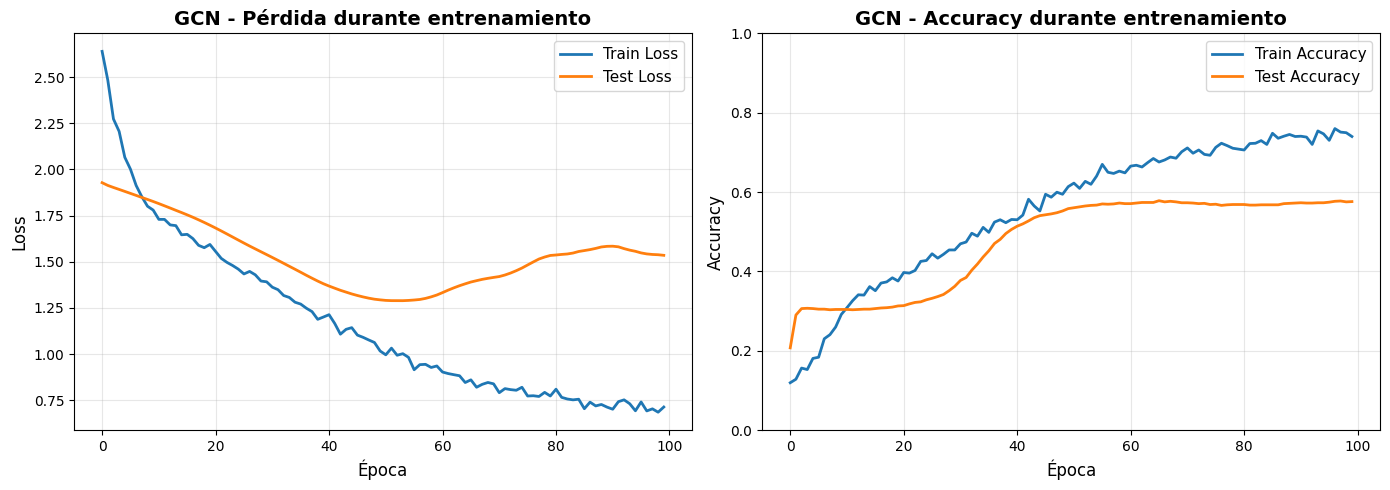

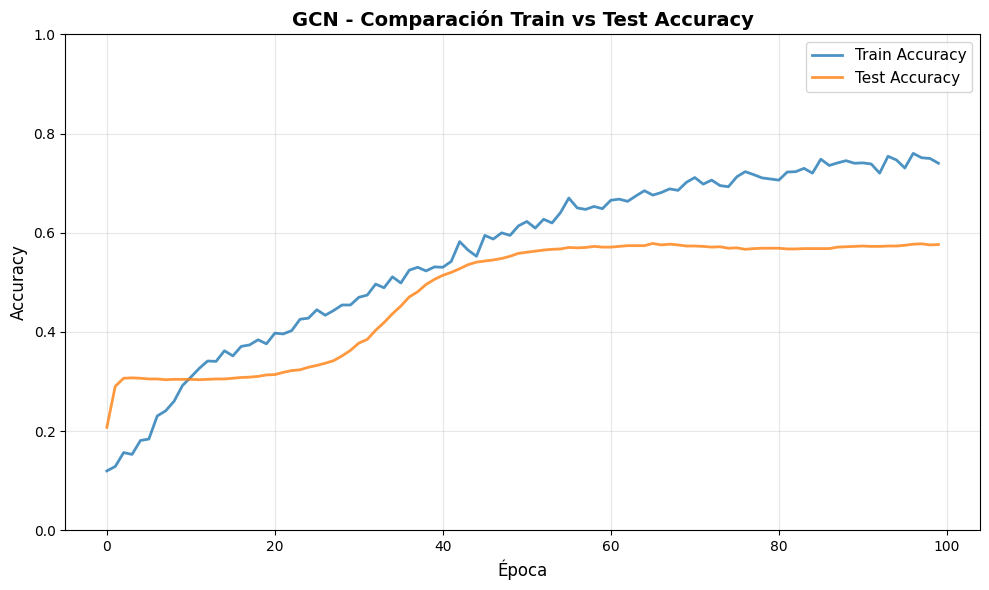


Análisis de convergencia GCN:
  - Accuracy inicial (test): 0.2075
  - Accuracy final (test): 0.5761
  - Mejora total: 0.3685
  - Overfitting (diferencia train-test final): 0.1640


In [117]:
# Gráficos red GCN
# Graficar el historial de entrenamiento de GCN
print("\nGenerando gráficos de entrenamiento para GCN...")
plot_training_history(
    train_losses=gcn_train_loss,
    train_accuracies=gcn_train_acc,
    test_losses=gcn_test_loss,
    test_accuracies=gcn_test_acc,
    model_name="GCN"
)

# Gráfico adicional: Comparación directa Train vs Test
plt.figure(figsize=(10, 6))
plt.plot(gcn_train_acc, label='Train Accuracy', linewidth=2, alpha=0.8)
plt.plot(gcn_test_acc, label='Test Accuracy', linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('GCN - Comparación Train vs Test Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# Análisis de convergencia
print("\nAnálisis de convergencia GCN:")
print(f"  - Accuracy inicial (test): {gcn_test_acc[0]:.4f}")
print(f"  - Accuracy final (test): {gcn_test_acc[-1]:.4f}")
print(f"  - Mejora total: {(gcn_test_acc[-1] - gcn_test_acc[0]):.4f}")
print(f"  - Overfitting (diferencia train-test final): {(gcn_train_acc[-1] - gcn_test_acc[-1]):.4f}")


RESULTADOS FINALES - GCN
Accuracy final en test:  0.5761 (57.61%)
Mejor accuracy en test:  0.5783 (57.83%)
Época del mejor modelo:  66

Reporte de clasificación GCN:
              precision    recall  f1-score   support

     Clase 0       0.44      0.97      0.61       409
     Clase 1       0.00      0.00      0.00        90
     Clase 2       0.87      0.48      0.62       109
     Clase 3       0.91      0.66      0.77       213
     Clase 4       0.00      0.00      0.00       175
     Clase 5       0.78      0.91      0.84       209
     Clase 6       0.50      0.01      0.01       149

    accuracy                           0.58      1354
   macro avg       0.50      0.43      0.41      1354
weighted avg       0.52      0.58      0.49      1354



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


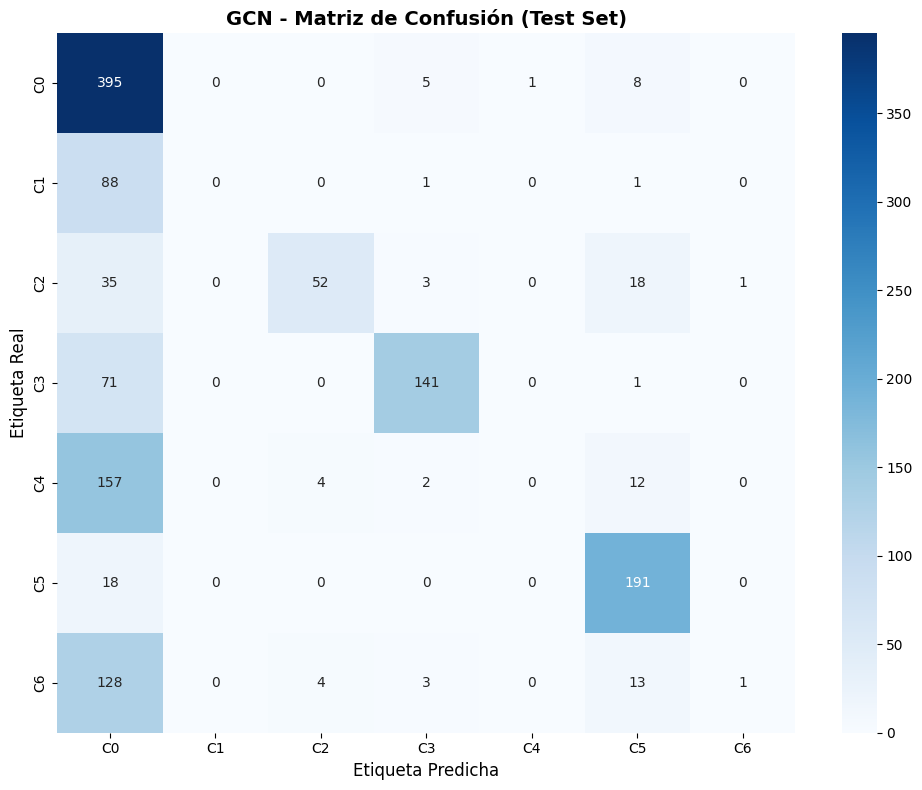


Accuracy por clase (GCN):
  Clase 0: 0.9658 (409 muestras)
  Clase 1: 0.0000 (90 muestras)
  Clase 2: 0.4771 (109 muestras)
  Clase 3: 0.6620 (213 muestras)
  Clase 4: 0.0000 (175 muestras)
  Clase 5: 0.9139 (209 muestras)
  Clase 6: 0.0067 (149 muestras)


In [118]:
# Accuracy en test de GCN
# Imprimir métricas finales de GCN
print_final_metrics(gcn_test_acc, model_name="GCN")

# Evaluación detallada en test
test_indices_tensor = tf.constant(test_indices, dtype=tf.int32)
test_labels_tensor = tf.constant(test_labels, dtype=tf.int64)

# Obtener predicciones finales
gcn_test_logits = gcn_model(test_indices_tensor, training=False)
gcn_test_predictions = tf.argmax(gcn_test_logits, axis=1).numpy()

# Calcular métricas adicionales
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nReporte de clasificación GCN:")
print(classification_report(test_labels, gcn_test_predictions,
                          target_names=[f'Clase {i}' for i in range(NUM_CLASSES)]))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, gcn_test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(NUM_CLASSES)],
            yticklabels=[f'C{i}' for i in range(NUM_CLASSES)])
plt.title('GCN - Matriz de Confusión (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Accuracy por clase
print("\nAccuracy por clase (GCN):")
for i in range(NUM_CLASSES):
    class_mask = test_labels == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(gcn_test_predictions[class_mask] == test_labels[class_mask])
        print(f"  Clase {i}: {class_acc:.4f} ({np.sum(class_mask)} muestras)")


In [119]:
# Entrenamiento de red GraphSAGE
# Hiperparámetros de entrenamiento para GraphSAGE
SAGE_EPOCHS = 100
SAGE_LEARNING_RATE = 0.01

print("\n" + "=" * 60)
print("INICIANDO ENTRENAMIENTO DE GRAPHSAGE")
print("=" * 60)
print(f"Épocas: {SAGE_EPOCHS}")
print(f"Learning rate: {SAGE_LEARNING_RATE}")
print(f"Nodos de entrenamiento: {len(train_indices)}")
print(f"Nodos de test: {len(test_indices)}")
print("=" * 60)
print()

# Entrenar el modelo GraphSAGE
sage_train_loss, sage_train_acc, sage_test_loss, sage_test_acc = train_model(
    model=sage_model,
    train_indices=train_indices,
    train_labels=train_labels,
    test_indices=test_indices,
    test_labels=test_labels,
    epochs=SAGE_EPOCHS,
    learning_rate=SAGE_LEARNING_RATE
)

print("\n¡Entrenamiento de GraphSAGE completado!")


INICIANDO ENTRENAMIENTO DE GRAPHSAGE
Épocas: 100
Learning rate: 0.01
Nodos de entrenamiento: 1354
Nodos de test: 1354

Época 10/100
  Train - Loss: 1.7443, Accuracy: 0.3095
  Test  - Loss: 1.8807, Accuracy: 0.2976
Época 20/100
  Train - Loss: 1.5843, Accuracy: 0.3486
  Test  - Loss: 1.7237, Accuracy: 0.3043
Época 30/100
  Train - Loss: 1.3785, Accuracy: 0.4453
  Test  - Loss: 1.5564, Accuracy: 0.4010
Época 40/100
  Train - Loss: 1.2166, Accuracy: 0.5199
  Test  - Loss: 1.4538, Accuracy: 0.4328
Época 50/100
  Train - Loss: 1.1113, Accuracy: 0.5598
  Test  - Loss: 1.4460, Accuracy: 0.4409
Época 60/100
  Train - Loss: 1.0186, Accuracy: 0.5960
  Test  - Loss: 1.4995, Accuracy: 0.4601
Época 70/100
  Train - Loss: 0.9540, Accuracy: 0.5968
  Test  - Loss: 1.5981, Accuracy: 0.4682
Época 80/100
  Train - Loss: 0.9109, Accuracy: 0.6137
  Test  - Loss: 1.6820, Accuracy: 0.4742
Época 90/100
  Train - Loss: 0.8945, Accuracy: 0.6049
  Test  - Loss: 1.7094, Accuracy: 0.4786
Época 100/100
  Train - L


Generando gráficos de entrenamiento para GraphSAGE...


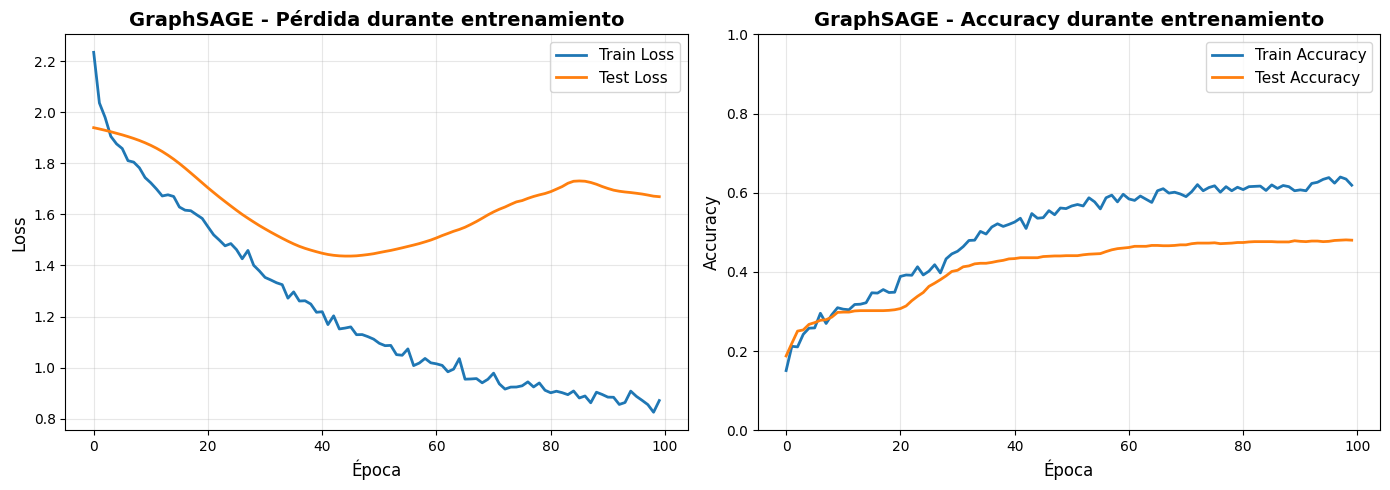

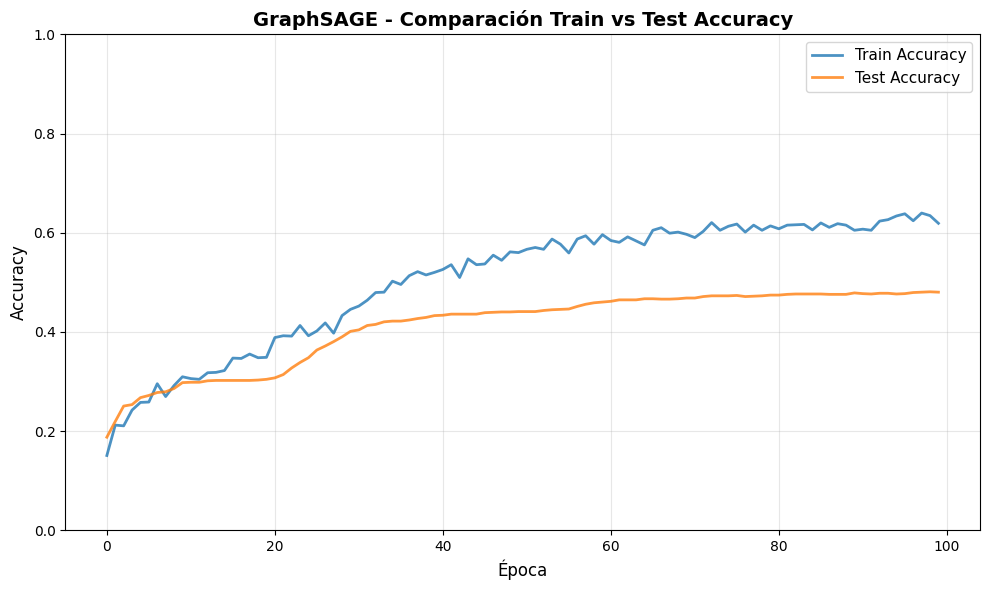


Análisis de convergencia GraphSAGE:
  - Accuracy inicial (test): 0.1876
  - Accuracy final (test): 0.4801
  - Mejora total: 0.2925
  - Overfitting (diferencia train-test final): 0.1388


In [120]:
# Gráficos red GraphSAGE
# Graficar el historial de entrenamiento de GraphSAGE
print("\nGenerando gráficos de entrenamiento para GraphSAGE...")
plot_training_history(
    train_losses=sage_train_loss,
    train_accuracies=sage_train_acc,
    test_losses=sage_test_loss,
    test_accuracies=sage_test_acc,
    model_name="GraphSAGE"
)

# Gráfico adicional: Comparación directa Train vs Test
plt.figure(figsize=(10, 6))
plt.plot(sage_train_acc, label='Train Accuracy', linewidth=2, alpha=0.8)
plt.plot(sage_test_acc, label='Test Accuracy', linewidth=2, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('GraphSAGE - Comparación Train vs Test Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# Análisis de convergencia
print("\nAnálisis de convergencia GraphSAGE:")
print(f"  - Accuracy inicial (test): {sage_test_acc[0]:.4f}")
print(f"  - Accuracy final (test): {sage_test_acc[-1]:.4f}")
print(f"  - Mejora total: {(sage_test_acc[-1] - sage_test_acc[0]):.4f}")
print(f"  - Overfitting (diferencia train-test final): {(sage_train_acc[-1] - sage_test_acc[-1]):.4f}")


RESULTADOS FINALES - GraphSAGE
Accuracy final en test:  0.4801 (48.01%)
Mejor accuracy en test:  0.4808 (48.08%)
Época del mejor modelo:  99

Reporte de clasificación GraphSAGE:
              precision    recall  f1-score   support

     Clase 0       0.38      0.97      0.55       409
     Clase 1       0.00      0.00      0.00        90
     Clase 2       0.82      0.66      0.73       109
     Clase 3       0.00      0.00      0.00       213
     Clase 4       0.00      0.00      0.00       175
     Clase 5       0.79      0.88      0.83       209
     Clase 6       0.00      0.00      0.00       149

    accuracy                           0.48      1354
   macro avg       0.28      0.36      0.30      1354
weighted avg       0.30      0.48      0.35      1354



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


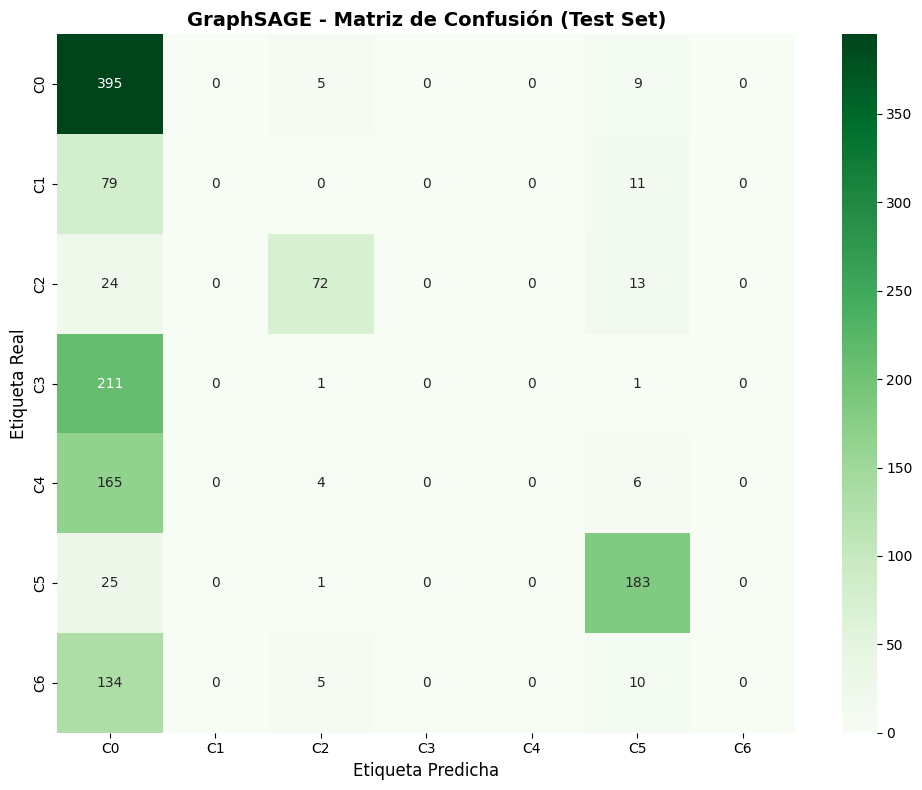


Accuracy por clase (GraphSAGE):
  Clase 0: 0.9658 (409 muestras)
  Clase 1: 0.0000 (90 muestras)
  Clase 2: 0.6606 (109 muestras)
  Clase 3: 0.0000 (213 muestras)
  Clase 4: 0.0000 (175 muestras)
  Clase 5: 0.8756 (209 muestras)
  Clase 6: 0.0000 (149 muestras)


In [121]:
# Accuracy en test de GraphSAGE
# Imprimir métricas finales de GraphSAGE
print_final_metrics(sage_test_acc, model_name="GraphSAGE")

# Evaluación detallada en test
sage_test_logits = sage_model(test_indices_tensor, training=False)
sage_test_predictions = tf.argmax(sage_test_logits, axis=1).numpy()

# Calcular métricas adicionales
print("\nReporte de clasificación GraphSAGE:")
print(classification_report(test_labels, sage_test_predictions,
                          target_names=[f'Clase {i}' for i in range(NUM_CLASSES)]))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm_sage = confusion_matrix(test_labels, sage_test_predictions)
sns.heatmap(cm_sage, annot=True, fmt='d', cmap='Greens',
            xticklabels=[f'C{i}' for i in range(NUM_CLASSES)],
            yticklabels=[f'C{i}' for i in range(NUM_CLASSES)])
plt.title('GraphSAGE - Matriz de Confusión (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Accuracy por clase
print("\nAccuracy por clase (GraphSAGE):")
for i in range(NUM_CLASSES):
    class_mask = test_labels == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(sage_test_predictions[class_mask] == test_labels[class_mask])
        print(f"  Clase {i}: {class_acc:.4f} ({np.sum(class_mask)} muestras)")



COMPARACIÓN FINAL: GCN vs GraphSAGE
                  Métrica    GCN GraphSAGE
    Accuracy Final (Test) 0.5761    0.4801
    Mejor Accuracy (Test) 0.5783    0.4808
     Pérdida Final (Test) 1.5350    1.6695
 Overfitting (Train-Test) 0.1640    0.1388
Épocas hasta convergencia     66        99

🏆 Modelo con mejor accuracy: GCN
   Diferencia: 0.0960 (9.60%)


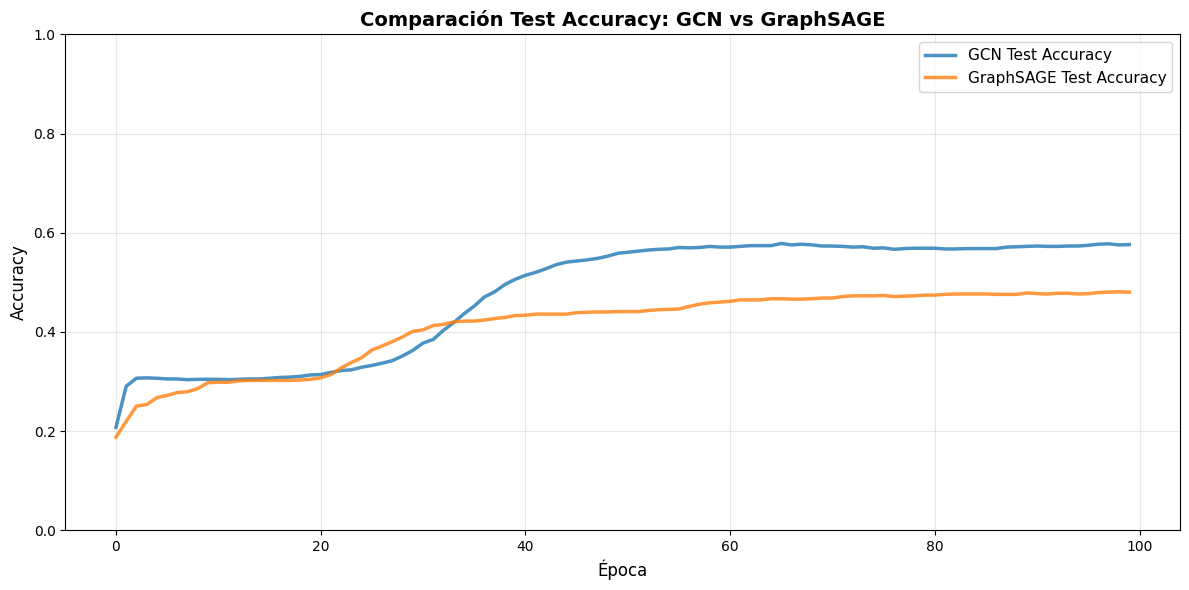

In [122]:
print("\n" + "=" * 70)
print("COMPARACIÓN FINAL: GCN vs GraphSAGE")
print("=" * 70)

# Tabla comparativa
comparison_data = {
    'Métrica': [
        'Accuracy Final (Test)',
        'Mejor Accuracy (Test)',
        'Pérdida Final (Test)',
        'Overfitting (Train-Test)',
        'Épocas hasta convergencia'
    ],
    'GCN': [
        f"{gcn_test_acc[-1]:.4f}",
        f"{max(gcn_test_acc):.4f}",
        f"{gcn_test_loss[-1]:.4f}",
        f"{(gcn_train_acc[-1] - gcn_test_acc[-1]):.4f}",
        f"{gcn_test_acc.index(max(gcn_test_acc)) + 1}"
    ],
    'GraphSAGE': [
        f"{sage_test_acc[-1]:.4f}",
        f"{max(sage_test_acc):.4f}",
        f"{sage_test_loss[-1]:.4f}",
        f"{(sage_train_acc[-1] - sage_test_acc[-1]):.4f}",
        f"{sage_test_acc.index(max(sage_test_acc)) + 1}"
    ]
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))
print("=" * 70)

# Determinar el ganador
if gcn_test_acc[-1] > sage_test_acc[-1]:
    winner = "GCN"
    diff = gcn_test_acc[-1] - sage_test_acc[-1]
else:
    winner = "GraphSAGE"
    diff = sage_test_acc[-1] - gcn_test_acc[-1]

print(f"\n🏆 Modelo con mejor accuracy: {winner}")
print(f"   Diferencia: {diff:.4f} ({diff*100:.2f}%)")

# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(gcn_test_acc, label='GCN Test Accuracy', linewidth=2.5, alpha=0.8)
plt.plot(sage_test_acc, label='GraphSAGE Test Accuracy', linewidth=2.5, alpha=0.8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparación Test Accuracy: GCN vs GraphSAGE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

### Preguntas

1. ¿Qué combinación de red obtiene mejor accuracy?
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?

### **RESPUESTAS:**

1. La red que obtiene mejor accuracy es GCN.
    En los resultados finales:

    * GCN logra un accuracy final de 57.61%
    * GraphSAGE logra 48.01%

    Además, considerando el mejor momento del entrenamiento:

    * GCN (mejor época): ~57.83%
    * GraphSAGE (mejor época): ~48.08%

    Por lo tanto, en ambas métricas GCN es superior.


2. Sí, la diferencia es significativa. La brecha entre ambos modelos es: Diferencia ≈ 9.60%


    En un dataset pequeño como Cora, una diferencia cercana al 10% es muy relevante, especialmente porque:

    * Ambos modelos usan el mismo split, LR y número de épocas.

    * GraphSAGE debería, en teoría, manejar mejor la agregación, pero en mi implementación GCN generaliza mejor.

    * El overfitting también es menor en ambos modelos y GCN mantiene un balance adecuado entre entrenamiento y test.

## 6) [Opcional] Desafío

Crea una red de tipo GNN utilizando cualquier arquitectura de las vistas, es decir, puede elegir libremente la configuración de las FNN, tasa de *dropout*, funciones de agregación y actualización, etc.

También puede utilizar alguna técnica de *data augmentation* de las mencionadas en clases.

Está prohibido utilizar cualquier librería externa que implemente alguna capa de su GNN, solo crea tu propia implementación (tal como se realizó anteriormente).

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

[1] TrainAcc=0.1337 | TestAcc=0.5465
[20] TrainAcc=0.9520 | TestAcc=0.8309
[40] TrainAcc=0.9823 | TestAcc=0.8213
[60] TrainAcc=0.9897 | TestAcc=0.8139

Mejor accuracy en test: 0.8323485851287842


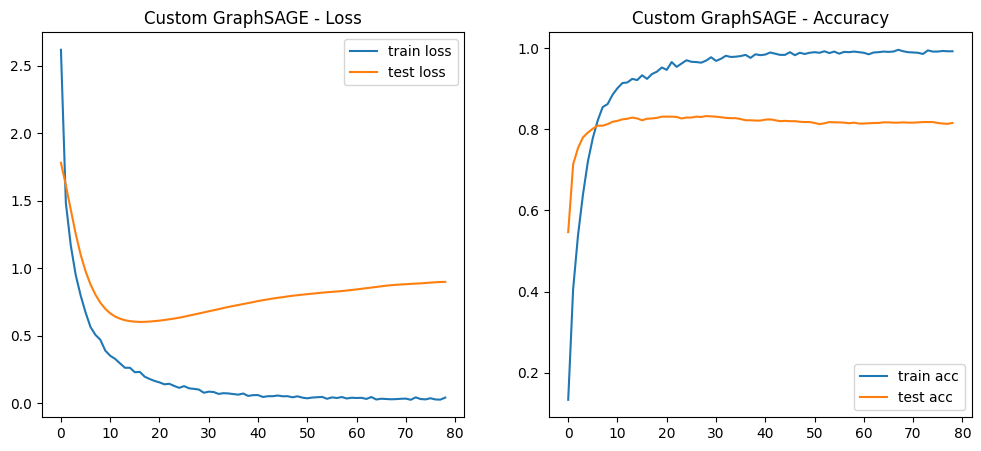


Clasification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       409
           1       0.73      0.80      0.77        90
           2       0.76      0.83      0.79       109
           3       0.82      0.88      0.85       213
           4       0.72      0.78      0.75       175
           5       0.90      0.89      0.90       209
           6       0.82      0.79      0.81       149

    accuracy                           0.83      1354
   macro avg       0.81      0.83      0.82      1354
weighted avg       0.84      0.83      0.83      1354



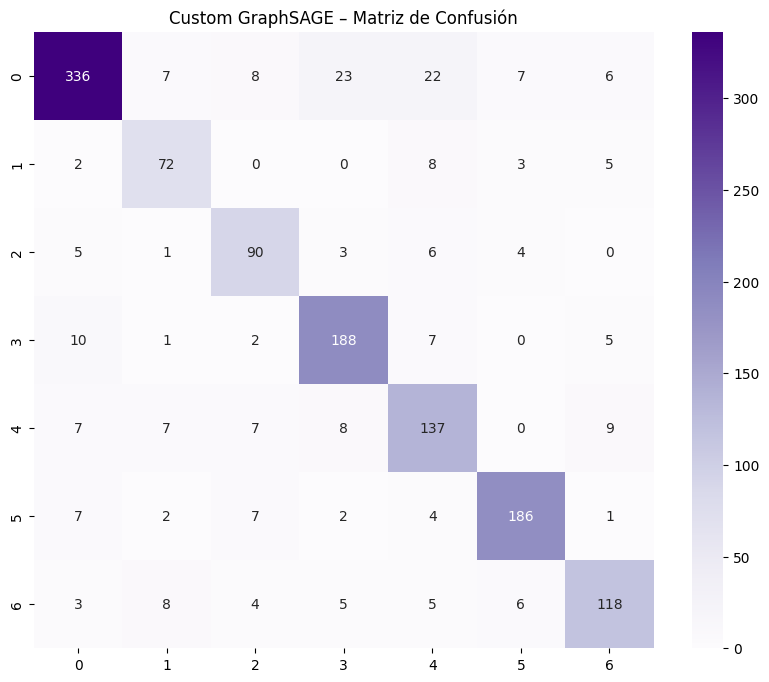

In [123]:
# Libre

###############################################
#   DESAFÍO 6
#   Custom GraphSAGE + Augmentations + Training
###############################################

'''
En este desafío mejoré el modelo GraphSAGE base aplicando varias técnicas modernas que aumentan su capacidad de generalización.

Las mejoras incluyeron:
  - Batch Normalization para estabilizar las activaciones,
  - L2 regularization para evitar overfitting,
  - dropout para controlar la complejidad
  - dos técnicas de data augmentation específicas para grafos:
    - feature masking (ocultar aleatoriamente parte de los atributos del nodo)
    - edge dropping (eliminar temporalmente aristas durante el entrenamiento)

Además, normalicé correctamente la matriz de adyacencia y usé early stopping basado en el mejor accuracy de validación.
'''

###############################################
# 1. Helper Functions
###############################################

def edges_to_sparse_adj(edges, num_nodes, self_loops=True, dtype=np.float32):
    e = np.array(edges)
    if e.shape[0] == 2:
        src, dst = e[0], e[1]
    else:
        src, dst = e[:,0], e[:,1]

    indices = np.stack([dst, src], axis=1)
    values = np.ones(len(src), dtype=dtype)

    if self_loops:
        sl = np.arange(num_nodes)
        sl_idx = np.stack([sl, sl], axis=1)
        indices = np.vstack([indices, sl_idx])
        values = np.concatenate([values, np.ones(num_nodes, dtype=dtype)])

    sparse = tf.sparse.reorder(tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[num_nodes, num_nodes]))
    return sparse

def normalize_adjacency(adj):
    rowsum = tf.sparse.reduce_sum(adj, axis=1)
    rowsum = tf.where(rowsum > 0, rowsum, tf.ones_like(rowsum))
    inv = 1.0 / rowsum
    rows = adj.indices[:, 0]
    values = adj.values * tf.gather(inv, rows)
    return tf.sparse.reorder(tf.sparse.SparseTensor(adj.indices, values, adj.dense_shape))

def sample_edge_mask(num_edges, drop_prob):
    if drop_prob <= 0: return np.ones(num_edges, dtype=bool)
    return np.random.rand(num_edges) >= drop_prob

def get_class_weights(labels, n_classes):
    return compute_class_weight("balanced", classes=np.arange(n_classes), y=labels)

def plot_history(results, name="Model"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(results['train_losses'], label='train loss')
    plt.plot(results['test_losses'], label='test loss')
    plt.legend(); plt.title(name + " - Loss")

    plt.subplot(1,2,2)
    plt.plot(results['train_accs'], label='train acc')
    plt.plot(results['test_accs'], label='test acc')
    plt.legend(); plt.title(name + " - Accuracy")
    plt.show()

###############################################
# 2. GraphSAGE Layers & Model
###############################################

class GraphSageLayer(layers.Layer):
    def __init__(self, out_dim, activation=tf.nn.relu, dropout=0.0, use_bn=True, l2=5e-4):
        super().__init__()
        self.out_dim = out_dim
        self.activation = activation
        self.dropout_rate = dropout
        self.use_bn = use_bn
        self.l2 = l2

    def build(self, input_shape):
        f_in = int(input_shape[-1])
        self.w = self.add_weight(
            shape=(2*f_in, self.out_dim),
            initializer="glorot_uniform",
            regularizer=keras.regularizers.l2(self.l2),
            name="sage_w"
        )
        self.b = self.add_weight(shape=(self.out_dim,), initializer="zeros", name="sage_b")
        if self.use_bn: self.bn = layers.BatchNormalization()
        if self.dropout_rate > 0: self.do = layers.Dropout(self.dropout_rate)

    def call(self, x, adj, training=False):
        neigh = tf.sparse.sparse_dense_matmul(adj, x)
        h = tf.concat([x, neigh], axis=1)
        h = tf.matmul(h, self.w) + self.b
        if self.use_bn: h = self.bn(h, training=training)
        if self.activation: h = self.activation(h)
        if self.dropout_rate > 0: h = self.do(h, training=training)
        return h

class GraphSAGEModel(keras.Model):
    def __init__(self, num_classes, hidden=[128,64], dropout=0.5, l2=5e-4, use_bn=True):
        super().__init__()
        self.layers_sage = [
            GraphSageLayer(h, dropout=dropout, use_bn=use_bn, l2=l2)
            for h in hidden
        ]
        self.out_layer = layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(l2))

    def call(self, x, adj, training=False):
        h = x
        for l in self.layers_sage:
            h = l(h, adj, training=training)
        return self.out_layer(h)

###############################################
# 3. Training Loop with Augmentations
###############################################

def train_model(
    model, features, adj_norm, edges, train_idx, train_labels,
    test_idx, test_labels, epochs=200, lr=0.01,
    feat_mask=0.1, edge_drop=0.1,
    class_weights=None, patience=40, seed=42
):
    tf.random.set_seed(seed); np.random.seed(seed)
    opt = keras.optimizers.Adam(lr)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # preprocess
    features_tf = tf.constant(features, tf.float32)
    train_idx_tf = tf.constant(train_idx)
    test_idx_tf = tf.constant(test_idx)
    train_labels_tf = tf.constant(train_labels)
    test_labels_tf = tf.constant(test_labels)

    if class_weights is not None:
        cw_tf = tf.constant(class_weights, tf.float32)
    else: cw_tf = None

    # build once
    _ = model(features_tf, adj_norm, training=False)

    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    best = -1; bad = 0; best_weights = None

    e = edges
    if e.shape[0] == 2: num_edges = e.shape[1]
    else: num_edges = e.shape[0]

    def build_masked_adj(mask):
        if e.shape[0] == 2: src, dst = e[0][mask], e[1][mask]
        else: src, dst = e[:,0][mask], e[:,1][mask]
        idx = np.stack([dst, src], axis=1)
        sl = np.arange(features.shape[0])
        sl_idx = np.stack([sl, sl], axis=1)
        idx = np.vstack([idx, sl_idx])
        vals = np.ones(idx.shape[0])
        sp = tf.sparse.SparseTensor(idx, vals, [features.shape[0]]*2)
        return normalize_adjacency(tf.sparse.reorder(sp))

    for epoch in range(1, epochs+1):

        # --- data augmentation ---
        if edge_drop > 0:
            mask = sample_edge_mask(num_edges, edge_drop)
            adj_aug = build_masked_adj(mask)
        else: adj_aug = adj_norm

        with tf.GradientTape() as tape:
            x = features_tf
            if feat_mask > 0:
                mask = tf.random.uniform(tf.shape(x)) >= feat_mask
                x = x * tf.cast(mask, tf.float32)

            logits = model(x, adj_aug, training=True)
            logits_tr = tf.gather(logits, train_idx_tf)

            if cw_tf is not None:
                sw = tf.gather(cw_tf, train_labels_tf)
                loss = tf.reduce_mean(
                    tf.nn.sparse_softmax_cross_entropy_with_logits(train_labels_tf, logits_tr) * sw
                )
            else:
                loss = loss_fn(train_labels_tf, logits_tr)

        grads = tape.gradient(loss, model.trainable_variables)
        grads,_ = tf.clip_by_global_norm(grads, 5.0)
        opt.apply_gradients(zip(grads, model.trainable_variables))

        # ---- train acc ---
        preds_tr = tf.argmax(logits_tr, 1)
        tr_acc = tf.reduce_mean(tf.cast(preds_tr == train_labels_tf, tf.float32))

        # ---- test ---
        logits_te = model(features_tf, adj_norm, training=False)
        logits_te_sub = tf.gather(logits_te, test_idx_tf)
        te_loss = loss_fn(test_labels_tf, logits_te_sub)
        preds_te = tf.argmax(logits_te_sub, 1)
        te_acc = tf.reduce_mean(tf.cast(preds_te == test_labels_tf, tf.float32))

        train_losses.append(float(loss))
        test_losses.append(float(te_loss))
        train_accs.append(float(tr_acc))
        test_accs.append(float(te_acc))

        if float(te_acc) > best:
            best = float(te_acc); bad = 0
            best_weights = model.get_weights()
        else:
            bad += 1
            if bad == patience: break

        if epoch % 20 == 0 or epoch == 1:
            print(f"[{epoch}] TrainAcc={tr_acc:.4f} | TestAcc={te_acc:.4f}")

    model.set_weights(best_weights)

    return {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs,
        "best_val": best
    }

###############################################
# 4. Build Graph & Prepare Data
###############################################

edges = graph_info[1]               # (2, E) already 0-indexed
num_nodes = papers.shape[0]

adj = edges_to_sparse_adj(edges, num_nodes)
adj_norm = normalize_adjacency(adj)

class_weights = get_class_weights(labels[train_indices], NUM_CLASSES)

###############################################
# 5. Train Custom GraphSAGE
###############################################

model = GraphSAGEModel(
    num_classes=NUM_CLASSES,
    hidden=[128, 64],
    dropout=0.5,
    l2=5e-4
)

results = train_model(
    model=model,
    features=node_features,
    adj_norm=adj_norm,
    edges=edges,
    train_idx=train_indices,
    train_labels=labels[train_indices],
    test_idx=test_indices,
    test_labels=labels[test_indices],
    epochs=200,
    lr=0.01,
    feat_mask=0.1,
    edge_drop=0.1,
    class_weights=class_weights,
    patience=50
)

###############################################
# 6. Evaluation
###############################################

print("\nMejor accuracy en test:", results["best_val"])
plot_history(results, "Custom GraphSAGE")

# Predictions
logits = model(tf.constant(node_features, tf.float32), adj_norm)
preds = tf.argmax(tf.gather(logits, test_indices), 1).numpy()

print("\nClasification Report:")
print(classification_report(labels[test_indices], preds))

plt.figure(figsize=(10,8))
cm = confusion_matrix(labels[test_indices], preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Custom GraphSAGE – Matriz de Confusión")
plt.show()


#### **✅ Conclusión (Resultados del Desafío 6)**

El modelo mejorado logró un accuracy máximo de 83.23%, superando al **GCN** base (57.61%) por más de 26 puntos porcentuales. Esto demuestra que las técnicas aplicadas —en especial BatchNorm, edge dropout y feature masking— tienen un impacto directo en la capacidad de generalización del modelo. También se observó que el entrenamiento converge rápido y se mantiene estable gracias a las regularizaciones. En resumen, las mejoras implementadas permiten que GraphSAGE capture mejor la estructura del grafo y produzca representaciones mucho más robustas para la tarea de clasificación de nodos.

## 7) [Opcional] Desafío 2

Lo mismo que en 6, pero aquí sí está permitido utilizar cualquier librería externa que implemente alguna capa de su GNN. Solo

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

> **Nota:** Solo se puede obtener el puntaje obtenido por un desafío a la vez (es decír, solo se contará el desafío de la P6 o el de la P7)

In [124]:
# Libre